In [1]:
from itertools import combinations
import pandas as pd
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from pandarallel import pandarallel
pandarallel.initialize()
import seaborn as sns

from scipy.stats import pearsonr, linregress


INFO: Pandarallel will run on 48 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


# Philipps data

In [2]:
df_list=[]
for i in tqdm(range(66)):
    df=pd.read_pickle(f"/home/athenes/Paraplume/data_with_scripts/repertoire_analysis/philipps/splits/paratope_9114_sequences_{i}.pkl")
    df_list.append(df)
total_df = pd.concat(df_list)

  0%|          | 0/66 [00:00<?, ?it/s]

100%|██████████| 66/66 [00:31<00:00,  2.09it/s]


In [3]:

mutation_columns = [
    'mutation_1', 'mutation_2', 'mutation_3', 'mutation_4', 'mutation_5',
    'mutation_6', 'mutation_7', 'mutation_8', 'mutation_9', 'mutation_10',
    'mutation_11', 'mutation_12', 'mutation_13', 'mutation_14',
    'mutation_15', 'mutation_16'
]
total_df[mutation_columns]=total_df[mutation_columns].astype(int)
total_df["mutations"] = total_df[mutation_columns].astype(str).agg("".join, axis=1)
total_df["total_mutations"]=total_df["mutations"].apply(lambda x:np.sum([int(char) for char in list(x)]))
total_df["paratope_size"]=total_df["model_prediction_heavy"].apply(lambda x:np.sum(x))+total_df["model_prediction_light"].apply(lambda x:np.sum(x))
total_df["binder H1"]=(total_df["H1_log10Kd"] <-7).astype(int)
total_df["binder H3"]=(total_df["H3_log10Kd"] <-6).astype(int)
total_df["binder FluB"]=(total_df["FluB_log10Kd"] <-6).astype(int)
total_df["mutations_vector"]=total_df["mutations"].apply(lambda x:[int(char) for char in x])


In [4]:
df_flub_binder = total_df.query("FluB_log10Kd<-6")
df_h1_binder = total_df.query("H1_log10Kd<-7")
df_h3_binder = total_df.query("H3_log10Kd<-6")

In [5]:
df_h1_control = total_df.query("H1_log10Kd==-7")


In [6]:
seed = 1
np.random.seed(seed)

sampled_df_h1 = df_h1_binder.dropna().sample(n=10000, random_state=seed).reset_index()
sampled_df_h3 = df_h3_binder.dropna().reset_index()
sampled_df_flub = df_flub_binder.dropna().reset_index()


# Naive vs HiFiBi0 mice

In [7]:
def calculate_mutations(row):
    heavy_mutations = np.sum([row["germline_heavy"][i]!=row["sequence_heavy"][i] for i in range(min(len(row["sequence_heavy"]), len(row["germline_heavy"])))])
    light_mutations = np.sum([row["germline_light"][i]!=row["sequence_light"][i] for i in range(min(len(row["sequence_light"]), len(row["germline_light"])))])
    return heavy_mutations + light_mutations

In [8]:
immunized_sequences = pd.read_pickle("/home/athenes/Paraplume/data_with_scripts/repertoire_analysis/hifibio&naive_mice/paratope_tt_sequences.pkl")
immunized_germlines = pd.read_pickle("/home/athenes/Paraplume/data_with_scripts/repertoire_analysis/hifibio&naive_mice/paratope_tt_germline.pkl")
naive_sequences = pd.read_pickle("/home/athenes/Paraplume/data_with_scripts/repertoire_analysis/hifibio&naive_mice/paratope_naive_sequences.pkl")
naive_germlines = pd.read_pickle("/home/athenes/Paraplume/data_with_scripts/repertoire_analysis/hifibio&naive_mice/paratope_naive_germline.pkl")

In [9]:
immunized_sequences["paratope_size"]=immunized_sequences["model_prediction_heavy"].apply(lambda x:np.sum(x))+immunized_sequences["model_prediction_light"].apply(lambda x:np.sum(x))
immunized_sequences["normalized_paratope_size"]=immunized_sequences["paratope_size"]/(immunized_sequences.sequence_heavy.str.len()+immunized_sequences.sequence_light.str.len())
naive_sequences["paratope_size"]=naive_sequences["model_prediction_heavy"].apply(lambda x:np.sum(x))+naive_sequences["model_prediction_light"].apply(lambda x:np.sum(x))
naive_sequences["normalized_paratope_size"]=naive_sequences["paratope_size"]/(naive_sequences.sequence_heavy.str.len()+naive_sequences.sequence_light.str.len())
naive_sequences["paratope_size"]=naive_sequences["model_prediction_heavy"].apply(lambda x:np.sum(x))+naive_sequences["model_prediction_light"].apply(lambda x:np.sum(x))
naive_sequences["normalized_paratope_size"]=naive_sequences["paratope_size"]/(naive_sequences.sequence_heavy.str.len()+naive_sequences.sequence_light.str.len())
naive_germlines["paratope_size"]=naive_germlines["model_prediction_heavy"].apply(lambda x:np.sum(x))+naive_germlines["model_prediction_light"].apply(lambda x:np.sum(x))
naive_germlines["normalized_paratope_size"]=naive_germlines["paratope_size"]/(naive_germlines.sequence_heavy.str.len()+naive_germlines.sequence_light.str.len())
immunized_sequences["paratope_size"]=immunized_sequences["model_prediction_heavy"].apply(lambda x:np.sum(x))+immunized_sequences["model_prediction_light"].apply(lambda x:np.sum(x))
immunized_sequences["normalized_paratope_size"]=immunized_sequences["paratope_size"]/(immunized_sequences.sequence_heavy.str.len()+immunized_sequences.sequence_light.str.len())
immunized_germlines["paratope_size"]=immunized_germlines["model_prediction_heavy"].apply(lambda x:np.sum(x))+immunized_germlines["model_prediction_light"].apply(lambda x:np.sum(x))
immunized_germlines["normalized_paratope_size"]=immunized_germlines["paratope_size"]/(immunized_germlines.sequence_heavy.str.len()+immunized_germlines.sequence_light.str.len())
immunized_sequences["germline_heavy"]=immunized_germlines["sequence_heavy"]
immunized_sequences["germline_light"]=immunized_germlines["sequence_light"]
naive_sequences["germline_heavy"]=naive_germlines["sequence_heavy"]
naive_sequences["germline_light"]=naive_germlines["sequence_light"]
immunized_sequences["mutation_count"]=immunized_sequences.apply(calculate_mutations, axis=1)
naive_sequences["mutation_count"]=naive_sequences.apply(calculate_mutations, axis=1)
immunized_sequences["clone_size"] = immunized_sequences.groupby("family")["family"].transform("count")
naive_sequences["clone_size"] = naive_sequences.groupby("family")["family"].transform("count")


# Figure 4

In [10]:
def create_strip_plot_data(sequences_df, germlines_df):
    """Helper function to create strip plot data"""
    mutation_count_sequences, paratope_size_sequences = [], []
    mutation_count_germlines, paratope_size_germlines = [], []

    for name, df in zip(["sequences", "germlines"], [sequences_df, germlines_df]):
        if name == "sequences":
            mutation_count_list, paratope_size_list = mutation_count_sequences, paratope_size_sequences
        else:
            mutation_count_list, paratope_size_list = mutation_count_germlines, paratope_size_germlines

        filtered_df = df.query("mutation_count < 21")[["model_prediction_heavy", "model_prediction_light", "mutation_count"]]
        for h, l, mut in filtered_df.values:
            paratope_size_list.append(np.sum(h) + np.sum(l))
            mutation_count_list.append(mut)

    return mutation_count_germlines, paratope_size_germlines, mutation_count_sequences, paratope_size_sequences

def plot_strip(ax, mutation_count_germlines, paratope_size_germlines,
               mutation_count_sequences, paratope_size_sequences, title="", show_ylabel=True, legend=True):
    """Helper function to create strip plots"""
    df_germlines = pd.DataFrame({"Mutation Count": mutation_count_germlines,
                                "Paratope Size": paratope_size_germlines, "Type": "Inferred germlines"})
    df_sequences = pd.DataFrame({"Mutation Count": mutation_count_sequences,
                                "Paratope Size": paratope_size_sequences, "Type": "Observed sequences"})
    df = pd.concat([df_germlines, df_sequences], ignore_index=True)

    bins = range(0, int(df["Mutation Count"].max()) + 3, 3)
    bin_labels = [f"{bins[i]}-{bins[i+1]-1}" for i in range(len(bins) - 1)]
    df["Mutation Bin"] = pd.cut(df["Mutation Count"], bins=bins, labels=bin_labels, right=True)
    df["Mutation Bin"] = pd.Categorical(df["Mutation Bin"], categories=bin_labels, ordered=True)

    sns.stripplot(x="Mutation Bin", y="Paratope Size", hue="Type", data=df,
                  dodge=True, alpha=0.1, legend=False, ax=ax,
                  palette={"Inferred germlines": "#1a80bb", "Observed sequences": "#a00000"})
    sns.pointplot(x="Mutation Bin", y="Paratope Size", hue="Type", data=df,
                  dodge=0.4, linestyle="none", errorbar=None, marker="_",
                  markersize=20, markeredgewidth=4, ax=ax,
                  palette={"Inferred germlines": "#1a80bb", "Observed sequences": "#a00000"})

    ax.set_ylim([20, 30])
    ax.set_yticks([20, 22, 24, 26, 28, 30])
    if not show_ylabel:
        ax.set_yticklabels([])
        ax.set_ylabel("")
    else:
        ax.set_ylabel("Paratope Size")

    ax.set_xlabel("Mutation count")
    xticks = [tick for tick in ax.get_xticks()]
    ax.set_xticks(xticks)
    ax.tick_params(axis='x', labelrotation=45)
    if legend:
        ax.legend(loc="upper right", bbox_to_anchor=(1.0, 1.0), borderaxespad=0.1, handletextpad=0.2,labelspacing=0.1, frameon=True)
    else:
        ax.legend_.remove()
    ax.set_title(title)
def process_combinations(differing_positions, mutation_dict, pred_1, pred_2,kd1,kd2, n, proba_dict, mode):
    for combo in combinations(differing_positions, n):
        muts = tuple(mutation_dict[pos] for pos in combo)
        if muts not in proba_dict:
            proba_dict[muts] = []
        if mode=="square":
            diff = sum((pred_1[mut] - pred_2[mut])**2 for mut in muts)
            fluB_log10Kd_diff_squared = (kd1 - kd2)**2
        elif mode=="abs":
            diff = sum([np.abs(pred_1[mut] - pred_2[mut]) for mut in muts])
            fluB_log10Kd_diff_squared = np.abs(kd1 - kd2)
        elif mode=="size":
            diff = np.abs(np.sum(pred_1)-np.sum(pred_2))
            fluB_log10Kd_diff_squared = np.abs(kd1 - kd2)
        proba_dict[muts].append([diff, fluB_log10Kd_diff_squared, ])

    return proba_dict

def get_proba_dict(sampled_df, strain, n, mode="square"):
    binary_vectors = np.array(sampled_df["mutations_vector"].tolist())
    hamming_distances = np.sum(np.abs(binary_vectors[:, None, :] - binary_vectors[None, :, :]), axis=2)
    pairs = np.argwhere(np.triu(hamming_distances, k=1) == n)

    df_1 = sampled_df.iloc[pairs[:, 0]].reset_index(drop=True)
    df_2 = sampled_df.iloc[pairs[:, 1]].reset_index(drop=True)

    df_1.reset_index(drop=True, inplace=True)
    df_2.reset_index(drop=True, inplace=True)
    df_1 = df_1.dropna(subset=["Unnamed: 0.2", "Unnamed: 0.1", "Unnamed: 0"])
    df_2 = df_2.dropna(subset=["Unnamed: 0.2", "Unnamed: 0.1", "Unnamed: 0"])

    mutation_dict = {0:28, 1:29, 2:30, 3:51, 4:56, 5:57, 6:58, 7:70, 8:73, 9:74, 10:75, 11:76, 12:83, 13:86, 14:94, 15:105}
    proba_dict = {}

    for i in tqdm(range(len(df_1))):

        vector_1 = np.array(df_1.iloc[i]["mutations_vector"])
        vector_2 = np.array(df_2.iloc[i]["mutations_vector"])
        differing_positions = np.where(vector_1 != vector_2)[0]

        pred_1 = df_1.iloc[i]["model_prediction_heavy"]
        pred_2 = df_2.iloc[i]["model_prediction_heavy"]

        kd1 = df_1.iloc[i][f"{strain}_log10Kd"]
        kd2 = df_2.iloc[i][f"{strain}_log10Kd"]
        proba_dict = process_combinations(differing_positions, mutation_dict, pred_1, pred_2, kd1, kd2, n, proba_dict, mode=mode)
    return proba_dict


In [11]:
plt.rcParams.update({
    "axes.titlesize": 38,
    "axes.labelsize": 35,
    "xtick.labelsize": 32,
    "ytick.labelsize": 32,
    "legend.fontsize": 33,
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern"],
})
FONT=28

100%|██████████| 373/373 [00:00<00:00, 4165.13it/s]
/tmp/ipykernel_2201568/2102984022.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_h1_control["strain"] = "Non"
/tmp/ipykernel_2201568/2102984022.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_h1_binder["strain"] = "H1"
/tmp/ipykernel_2201568/2102984022.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

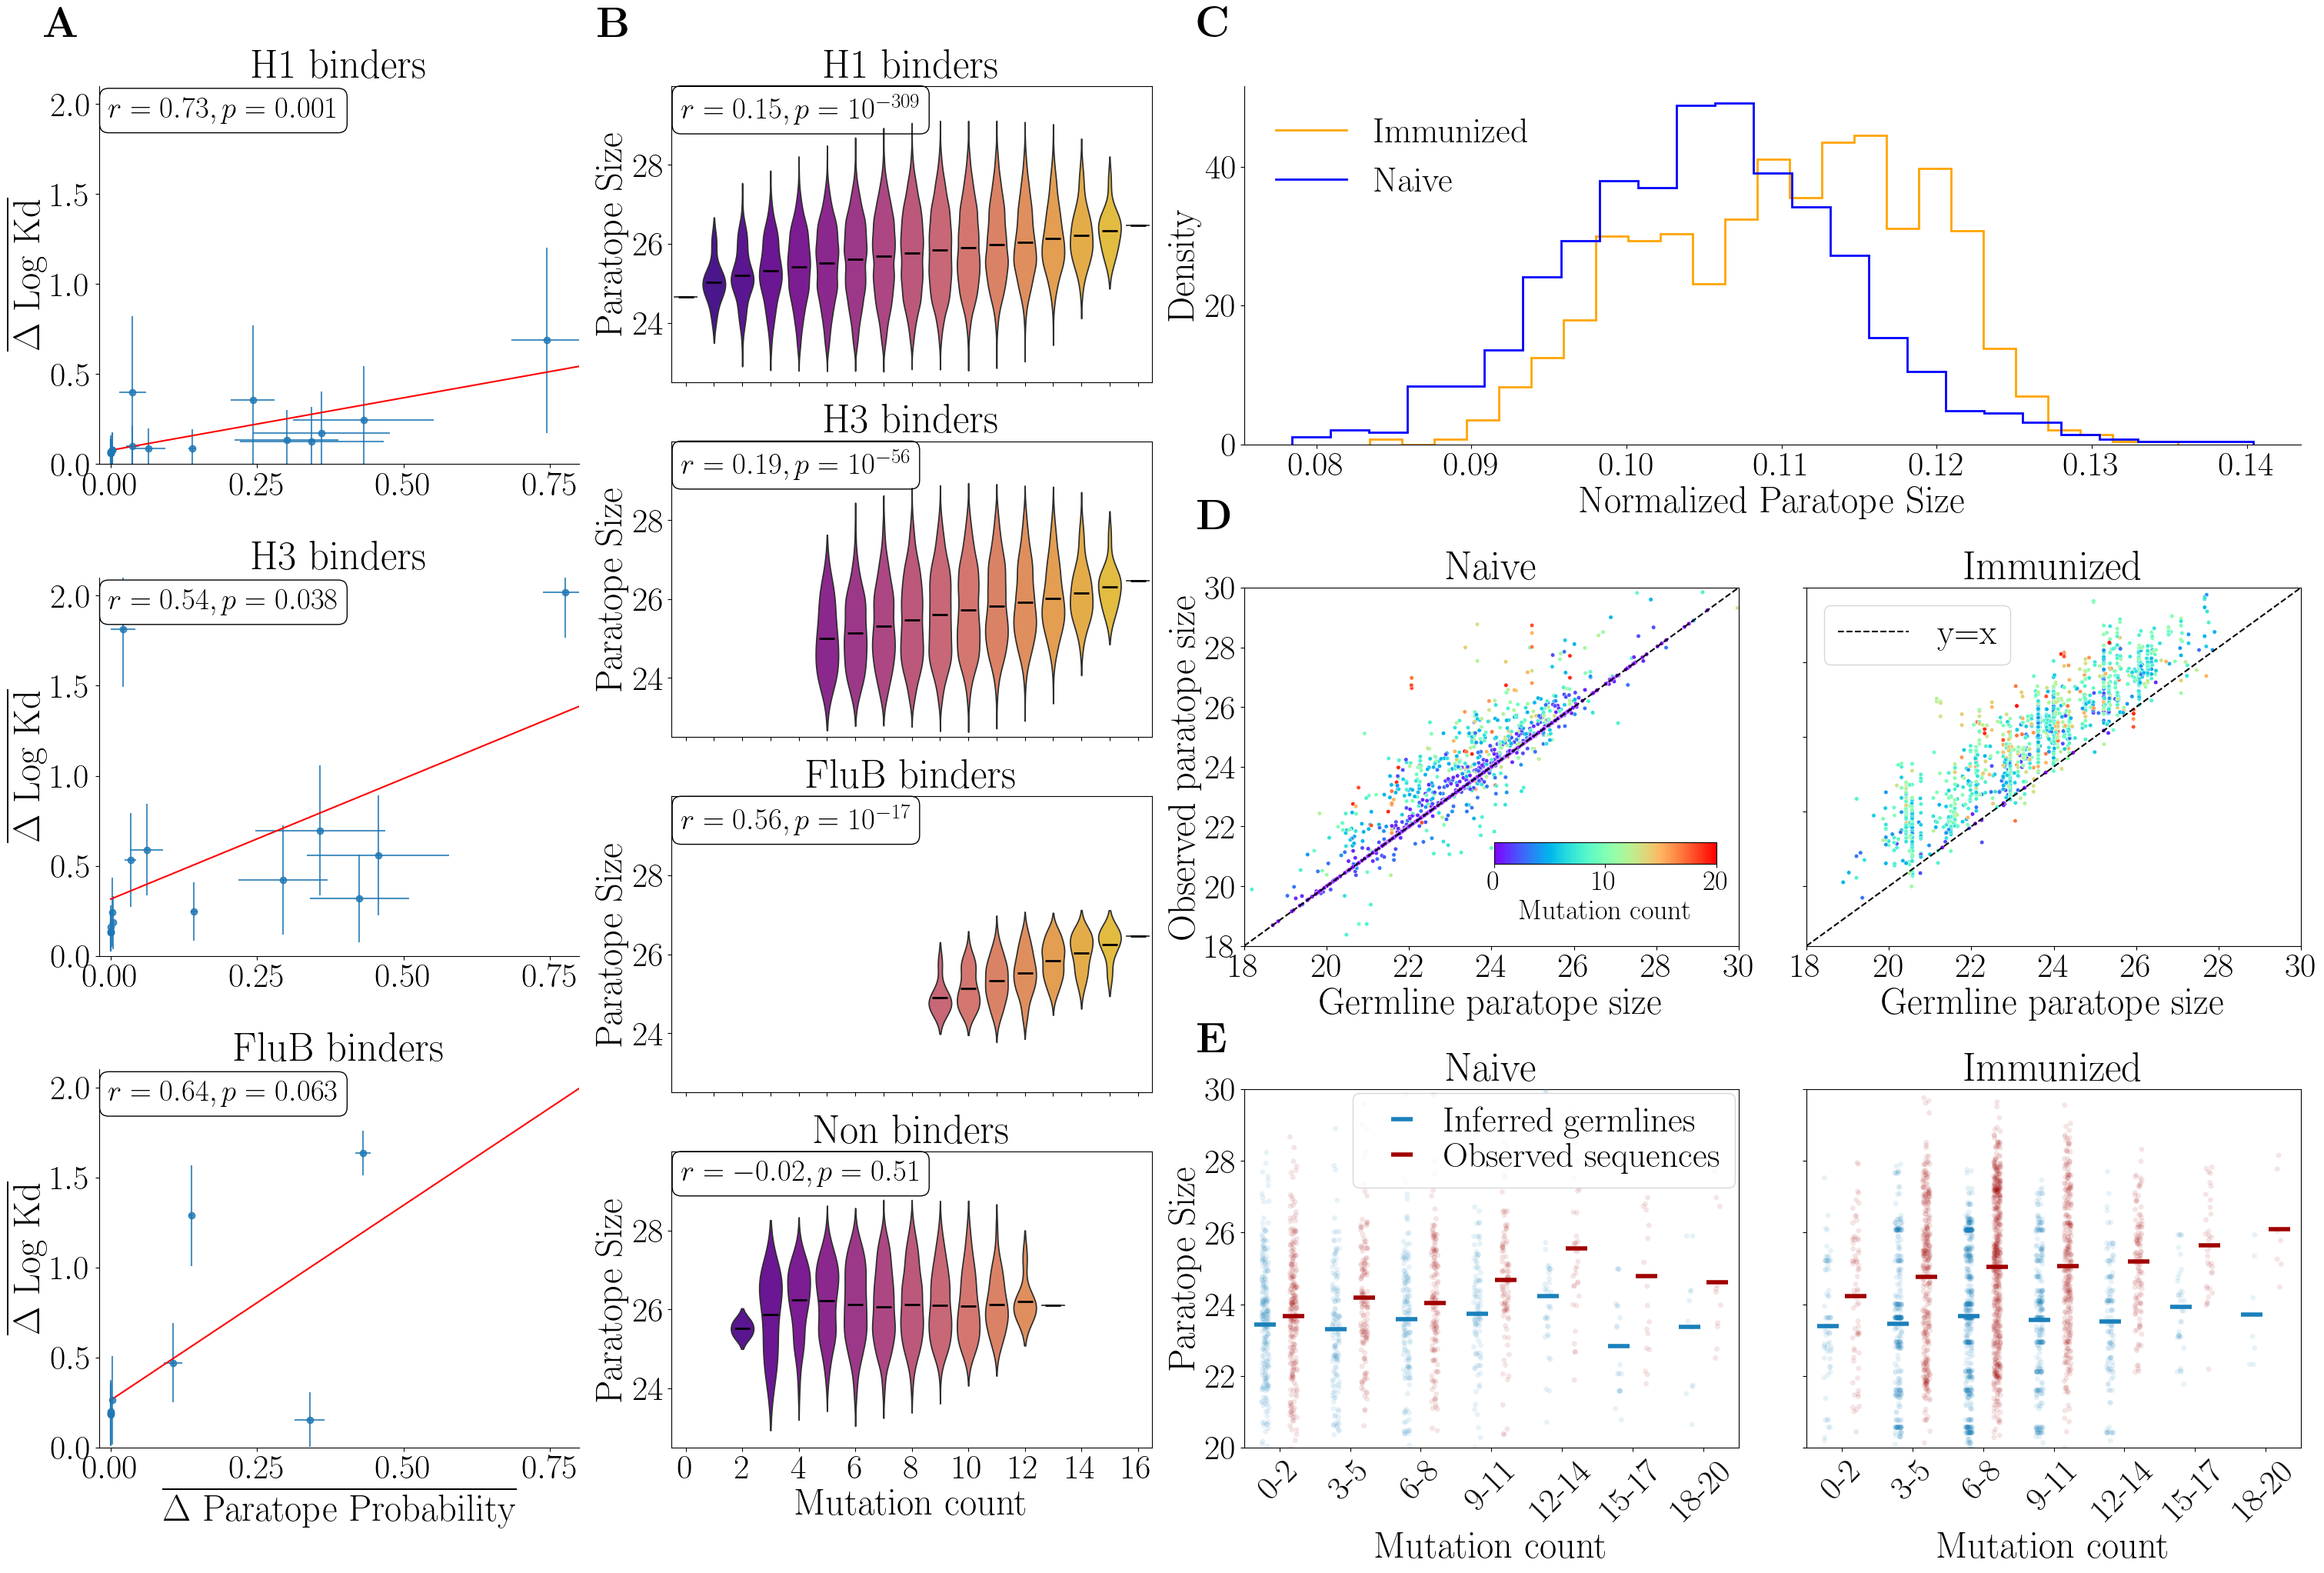

In [14]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import pearsonr, linregress
from matplotlib.lines import Line2D

# Set up the figure with custom gridspec for 3-column layout
fig = plt.figure(figsize=(30, 20))
gs_main = gridspec.GridSpec(1, 3, figure=fig, width_ratios=[1, 1, 2.2])  # Adjusted width ratios
gs_col1 = gridspec.GridSpecFromSubplotSpec(3, 1, gs_main[0, 0], height_ratios=[1, 1, 1], hspace=0.3)
gs_col2 = gridspec.GridSpecFromSubplotSpec(4, 1, gs_main[0, 1], height_ratios=[1, 1, 1, 1])
gs_col3 = gridspec.GridSpecFromSubplotSpec(3, 2, gs_main[0, 2], height_ratios=[1, 1, 1], hspace=0.4)  # Adjusted height ratios

# COLUMN 1: Correlation plots (3 subplots spanning first 3 rows)
strains = ["H1", "H3", "FluB"]
dfs = [sampled_df_h1, sampled_df_h3, sampled_df_flub]

# Create axes for column 1 correlation plots
ax_left = [fig.add_subplot(gs_col1[i, 0]) for i in range(3)]

for ax, strain, df in zip(ax_left, strains, dfs):
    proba_dict = get_proba_dict(df, strain=strain, n=1, mode="abs")

    xs = [np.mean([each[0] for each in proba_dict[i]]) for i in proba_dict.keys()]
    ys = [np.mean([each[1] for each in proba_dict[i]]) for i in proba_dict.keys()]
    y_err = [np.std([each[1] for each in proba_dict[i]]) for i in proba_dict.keys()]  # Standard deviation
    x_err = [np.std([each[0] for each in proba_dict[i]]) for i in proba_dict.keys()]  # Standard deviation

    xs = np.array(xs)
    ys = np.array(ys)
    y_err = np.array(y_err)
    x_err = np.array(x_err)

    ax.errorbar(xs, ys, yerr=y_err,xerr=x_err, fmt='o', alpha=0.8)  # Add error bars

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    corr, p_value = pearsonr(xs, ys)
    slope, intercept, _, _, _ = linregress(xs, ys)
    common_xs = np.linspace(0, 1, 1000)
    regression_line = slope * common_xs + intercept
    ax.plot(common_xs, regression_line, color='red')

    # Determine p-value format
    if p_value < 0.001:
        exponent = np.ceil(np.log10(p_value)).astype(int)
        p_display = f"p = 10^{{{exponent}}}"
    else:
        p_display = f"p = {p_value:.3f}"

    ax.annotate(rf"$r={corr:.2f}, {p_display}$", xy=(0.02, 0.97), xycoords='axes fraction',
                ha='left', va='top',
                bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white'), fontsize=FONT)

    ax.set_ylabel(r'$\overline{\Delta \ \mathrm{Log\ Kd}}$')
    if strain=="FluB":
        ax.set_xlabel(r'$\overline{\Delta \ \mathrm{Paratope\ Probability}}$')
    ax.set_title(rf"{strain} binders")
    ax.set_ylim([0, 2.1])
    ax.set_xlim([-0.02, 0.8])


# COLUMN 2: Violin plots (4 rows including h1_control)
# Prepare data for violin plots
df_h1_control["strain"] = "Non"
df_h1_binder["strain"] = "H1"
df_h3_binder["strain"] = "H3"
df_flub_binder["strain"] = "FluB"

df_combined = pd.concat([df_h1_binder, df_h3_binder, df_flub_binder, df_h1_control])
df_combined["total_mutations"] = df_combined["total_mutations"].astype(str)

sorted_mutations = sorted(df_combined["total_mutations"].unique(), key=lambda x: int(x))
colors = sns.color_palette("plasma", n_colors=len(sorted_mutations))
color_dict = {mutation: color for mutation, color in zip(sorted_mutations, colors)}

# Create violin plot axes (4 strains including Non/h1_control)
strain_order = ["H1", "H3", "FluB", "Non"]
ax_violin = [fig.add_subplot(gs_col2[i, 0]) for i in range(4)]

for ax, strain in zip(ax_violin, strain_order):
    subset = df_combined[df_combined["strain"] == strain]
    sns.violinplot(data=subset, x="total_mutations", y="paratope_size",
                   palette=color_dict, inner=None, order=sorted_mutations, ax=ax)

    # Overlay mean points
    means = subset.groupby("total_mutations")["paratope_size"].mean()
    sns.pointplot(x=means.index, y=means.values, color="black", ax=ax,
                  linestyle="none", errorbar=None, marker="_", markersize=15)

    ax.set_title(f"{strain} binders")
    ax.set_ylabel("Paratope Size")
    ax.set_ylim(22.5, 30)
    ax.set_yticks([24, 26, 28])

    correlation, p_value = pearsonr(subset["total_mutations"].astype(float), subset["paratope_size"])
    if p_value < 0.01:
        exponent = np.ceil(np.log10(p_value)).astype(int)
        p_display = f"p = 10^{{{exponent}}}"
    else:
        p_display = f"p = {p_value:.2f}"

    ax.annotate(rf"$r={correlation:.2f}, {p_display}$", xy=(0.02, 0.97), xycoords='axes fraction',
                ha='left', va='top',
                bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='none'), fontsize=FONT)

    # Remove x-axis label and tick labels for the first three rows
    if strain != "Non":
        ax.set_xticklabels([])
        ax.set_xlabel("")
    else:
        xticks = [tick for tick in ax.get_xticks() if tick % 2 == 0]
        ax.set_xticks(xticks)

# Only bottom violin plot gets x-label
ax_violin[-1].set_xlabel("Mutation count")

# COLUMN 3: The 5 plots
# HISTOGRAM (top of column 3, spanning all 2 sub-columns)
ax_hist = fig.add_subplot(gs_col3[0, :])
bins = 25
ax_hist.hist(immunized_sequences["normalized_paratope_size"], bins=bins, density=True,
             histtype='step', linewidth=2, color='orange', label='Immunized')
ax_hist.hist(naive_sequences["normalized_paratope_size"], bins=bins, density=True,
             histtype='step', linewidth=2, color='blue', label='Naive')
ax_hist.spines['top'].set_visible(False)
ax_hist.spines['right'].set_visible(False)
ax_hist.set_xlabel("Normalized Paratope Size")
ax_hist.set_ylabel("Density")

legend_lines = [
    Line2D([0], [0], color="orange", lw=2, label="Immunized"),
    Line2D([0], [0], color="blue", lw=2, label="Naive"),
]
ax_hist.legend(handles=legend_lines, loc='upper left', frameon=False)

# 2x2 GRID for the remaining 4 plots
# SCATTER PLOTS (row 1)
# Left scatter plot (Naive)
ax_scatter_left = fig.add_subplot(gs_col3[1, 0])
y = naive_sequences.query("mutation_count<21")["paratope_size"].tolist()
naive_germlines["mutation_count"] = naive_sequences["mutation_count"]
x = naive_germlines.query("mutation_count<21")["paratope_size"].tolist()
c = naive_sequences.query("mutation_count<21")["mutation_count"]

sns.scatterplot(x=x, y=y, hue=c, palette="rainbow", s=15, ax=ax_scatter_left, legend=False)
x_range = list(range(18, 31, 1))
ax_scatter_left.plot(x_range, x_range, color="black", linestyle="--")
ax_scatter_left.set_xlabel("Germline paratope size")
ax_scatter_left.set_ylabel("Observed paratope size")
ax_scatter_left.set_title("Naive")
ax_scatter_left.set_xlim([18, 30])
ax_scatter_left.set_ylim([18, 30])
ticks = np.arange(18, 31, 2)
ax_scatter_left.set_xticks(ticks)
ax_scatter_left.set_yticks(ticks)
norm = plt.Normalize(vmin=min(c), vmax=max(c))
sm = plt.cm.ScalarMappable(cmap="rainbow", norm=norm)
sm.set_array([])
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
cax = inset_axes(ax_scatter_left,
                 width="50%",  # width of colorbar relative to the axis
                 height="3%",  # height of colorbar
                 loc='lower center',  # location: bottom center inside the plot
                 bbox_to_anchor=(0.28, 0.23, 0.9, 2),  # [x0, y0, width, height]
                 bbox_transform=ax_scatter_left.transAxes,
                 borderpad=0)

cbar = plt.colorbar(sm, cax=cax, orientation='horizontal')
cbar.set_label(r"Mutation count", fontsize=26)
cbar.ax.tick_params(labelsize=26)
# Right scatter plot (Immunized)
ax_scatter_right = fig.add_subplot(gs_col3[1, 1])
y = immunized_sequences.query("mutation_count<21")["paratope_size"].tolist()
immunized_germlines["mutation_count"] = immunized_sequences["mutation_count"]
x = immunized_germlines.query("mutation_count<21")["paratope_size"].tolist()
c = immunized_sequences.query("mutation_count<21")["mutation_count"]

sns.scatterplot(x=x, y=y, hue=c, palette="rainbow", s=15, ax=ax_scatter_right, legend=False)
ax_scatter_right.plot(x_range, x_range, color="black", linestyle="--", label="y=x")
ax_scatter_right.set_xlim([18, 30])
ax_scatter_right.set_ylim([18, 30])
ax_scatter_right.set_title("Immunized")
ax_scatter_right.legend(loc="upper left")
ax_scatter_right.set_xlabel("Germline paratope size")
ax_scatter_right.set_yticklabels([])
ax_scatter_right.set_xticks(ticks)



# STRIP PLOTS (row 2)
# Left strip plot (Naive)
ax_strip_left = fig.add_subplot(gs_col3[2, 0])
mut_germ, para_germ, mut_seq, para_seq = create_strip_plot_data(naive_sequences, naive_germlines)
plot_strip(ax_strip_left, mut_germ, para_germ, mut_seq, para_seq, "Naive", show_ylabel=True)

# Right strip plot (Immunized)
ax_strip_right = fig.add_subplot(gs_col3[2, 1])
mut_germ, para_germ, mut_seq, para_seq = create_strip_plot_data(immunized_sequences, immunized_germlines)
plot_strip(ax_strip_right, mut_germ, para_germ, mut_seq, para_seq, "Immunized", show_ylabel=False, legend=False)
# Add big bold letters for figure panels
fig.text(0.01, 1.02, r'\textbf{A}', fontsize=40, fontweight='bold', va='top', ha='left')  # Top left of Column 1
fig.text(0.25, 1.02, r'\textbf{B}', fontsize=40, fontweight='bold', va='top', ha='left')  # Top left of Column 2
fig.text(0.51, 1.02, r'\textbf{C}', fontsize=40, fontweight='bold', va='top', ha='left')  # Top left of 1st row, Column 3
fig.text(0.51, 0.7, r'\textbf{D}', fontsize=40, fontweight='bold', va='top', ha='left')  # Top left of 2nd row, Column 3
fig.text(0.51, 0.36, r'\textbf{E}', fontsize=40, va='top', ha='left')  # Top left of 3rd row, Column 3
plt.tight_layout()
plt.savefig("/home/athenes/Paraplume/data_with_scripts/plots/figure4.pdf", bbox_inches='tight')
plt.show()
